In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 8)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [4]:
import re
import urllib2
import datetime

import numpy  as np

from collections import Counter, OrderedDict

from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation, get_sun
from astropy.time import Time
from astropy.utils.data import get_readable_fileobj
from astropy.io import fits
from astropy.table import Table, QTable, Column, MaskedColumn
from astropy import table

In [5]:
for module in ['hosts', 'targeting', 'aat']:
    if module in globals():
        reload(globals()[module])
    else:
        globals()[module] = __import__(module)
#g = targeting.get_gama() #re-caches the gama catalog

In [6]:
hsd = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
hsd = dict([(h.name, h) for h in hsd])

Using cached version of google hosts list from file "hosts_dl.pkl2"


Note: originally this came from 2017Jul-AAT

# Fitting of gri_err for Marla

In [223]:
from astropy import modeling
from astropy.stats import sigma_clip

In [224]:
ody = hsd['Odyssey']
gilg = hsd['Gilgamesh']
hostobjs = [ody, gilg]
    
for h in hostobjs:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None
    
for h in hostobjs:
    h.get_sdss_catalog()

## Experiment with Odyssey

In [249]:
cat = ody.get_sdss_catalog()

In [250]:
gri_err = reduce(np.add, [cat[bandnm+'_err'] for bandnm in 'gri']).view(np.ndarray).astype(float)/3

In [251]:
def plot_data_and_model_residuals(x, y, xlims, ylims, mod, zoomfactor=5):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12, 12))

    xmod = np.linspace(xlims[0], xlims[1], 100)
    ymod = mod(xmod)

    for i, ax in enumerate((ax1, ax2)):
        ax.scatter(x, y, alpha=.02+ .05*i, lw=0,s=3)
        ax.plot(xmod, ymod, c='r')
        ax.set_xlim(*xlims)
        ax.set_xlabel('r mag')
        ax.set_ylabel('(g_err + r_err + i_err)/3')

    ax1.set_ylim(*ylims)
    ax2.set_ylim(0, ylims[1]/zoomfactor)


    for i, ax in enumerate((ax3, ax4)):
        ax.scatter(x, y-mod(x), alpha=.03, lw=0,s=3)
        ax.set_xlim(*xlims)
        ax.set_xlabel('r mag')
        ax.set_ylabel('residuals')
        ax.axhline(0, color='k', ls=':')

    ax3.set_ylim(-ylims[1], ylims[1])
    ax4.set_ylim(-ylims[1]/zoomfactor, ylims[1]/zoomfactor)
    
    return fig

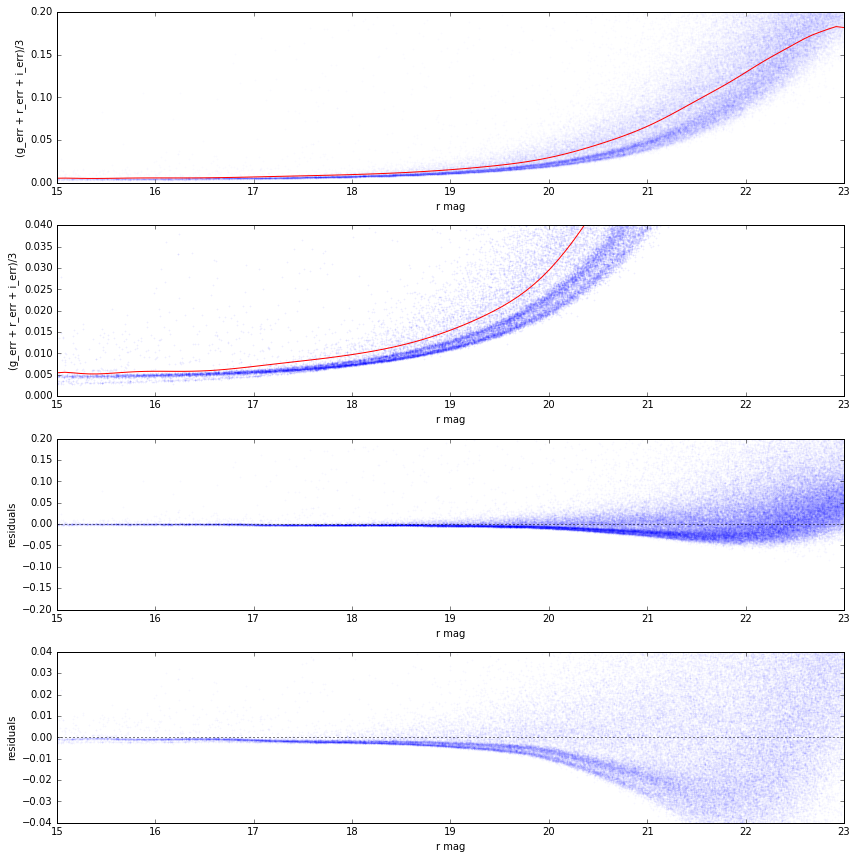

In [252]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

mod0 = modeling.models.Polynomial1D(degree=55, domain=xlims, window=[0, 1])
mod = modeling.fitting.LinearLSQFitter()(mod0, x[lims], y[lims])

plot_data_and_model_residuals(x, y, xlims, ylims, mod)
plt.tight_layout()

Just fitting a polynomial doesnt work because of all the outliers.  Try using the binned median and fit *that*

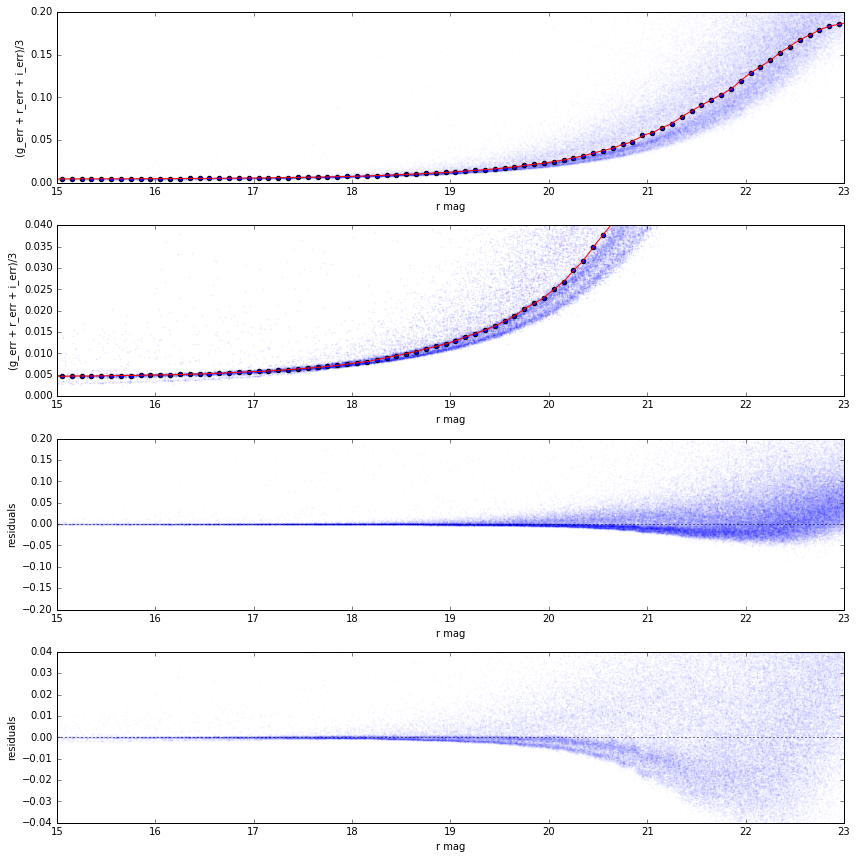

In [253]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

binsize = .1
rbins = np.arange(xlims[0], xlims[1]+binsize, binsize)

# first get the values in the bins
binned_errs = [y[(l<x)&(x<u)&(ylims[0]<y)&(y<ylims[1])] for l, u in zip(rbins[:-1], rbins[1:])]
bincens_mag = [(l+u)/2 for l, u in zip(rbins[:-1], rbins[1:])]

#now compute the median in each bin
binvalues = [np.median(b) for b in binned_errs]

mod = lambda x: np.interp(x, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod)
fig.axes[0].scatter(bincens, binvalues)
fig.axes[1].scatter(bincens, binvalues)
plt.tight_layout()

Still doesn't look very good.  Lets try sigma-clipping before medianing

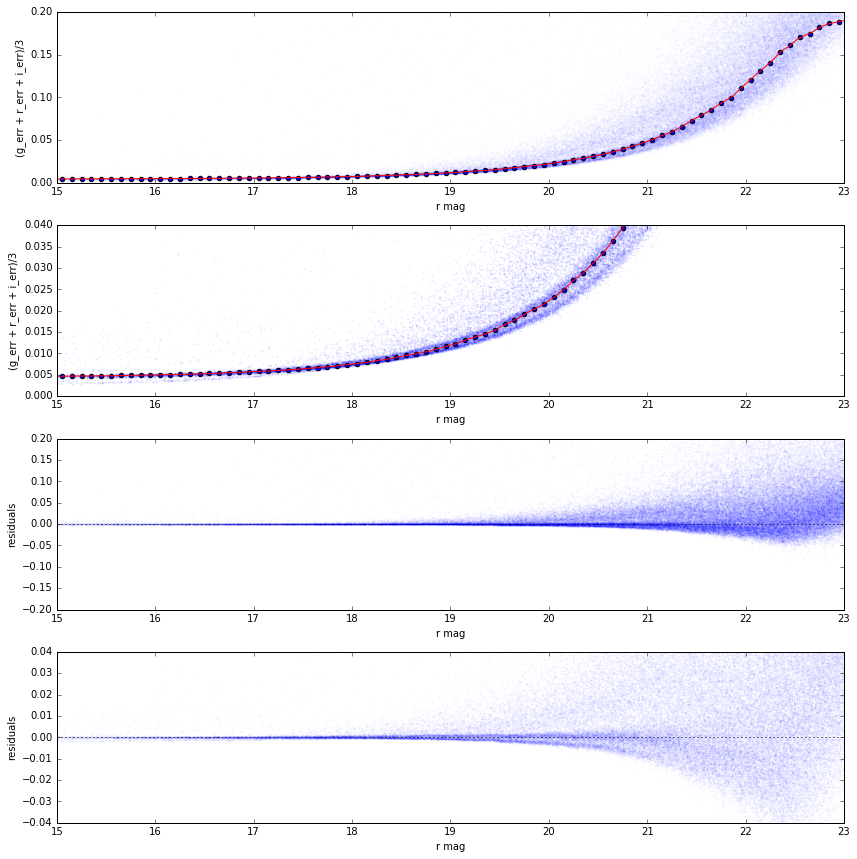

In [254]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

binsize = .1
rbins = np.arange(xlims[0], xlims[1]+binsize, binsize)
# first get the values in the bins
binned_errs = [y[(l<x)&(x<u)&(ylims[0]<y)&(y<ylims[1])] for l, u in zip(rbins[:-1], rbins[1:])]
bincens_mag = [(l+u)/2 for l, u in zip(rbins[:-1], rbins[1:])]

#sigma clip and then compute the median of that 
clipped_errs = [sigma_clip(b, sigma=2) for b in binned_errs]
binvalues = [np.median(v[~v.mask])for v in clipped_errs]

mod = lambda x: np.interp(x, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod)
fig.axes[0].scatter(bincens, binvalues)
fig.axes[1].scatter(bincens, binvalues)
plt.tight_layout()

Seems more promising.  Now just need a more convenient fit to the binned points

<Polynomial1D(15, c0=0.005149257478939193, c1=-0.09472825642564356, c2=5.358273421872663, c3=-134.39850642689152, c4=1870.454564642886, c5=-16130.383027673597, c6=92235.35916295765, c7=-364811.8217492756, c8=1024022.8001561066, c9=-2066815.7838064728, c10=3005079.4972476815, c11=-3115500.530979867, c12=2243407.7683357825, c13=-1064525.7410173835, c14=298820.0833916113, c15=-37522.3827550569)>

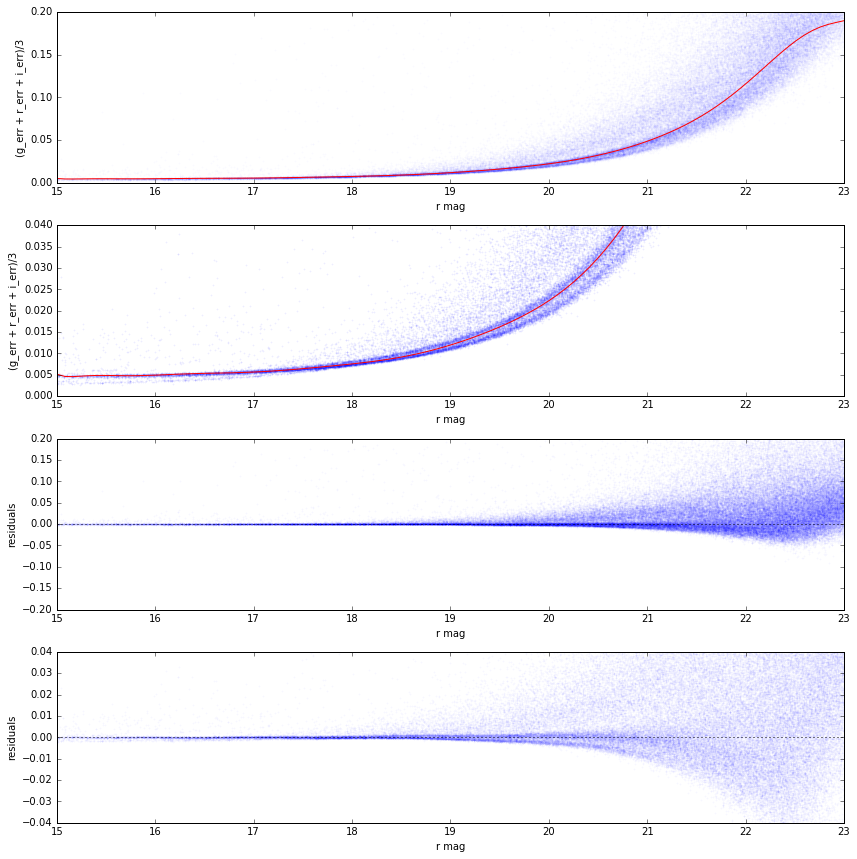

In [255]:
mod0 = modeling.models.Polynomial1D(degree=15, domain=xlims, window=[0, 1])
mod_ody = modeling.fitting.LinearLSQFitter()(mod0, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod_ody)
plt.tight_layout()
mod_ody

## See if the same thing works for Gilgamesh 

In [256]:
cat = gilg.get_sdss_catalog()

In [257]:
gri_err = reduce(np.add, [cat[bandnm+'_err'] for bandnm in 'gri']).view(np.ndarray).astype(float)/3

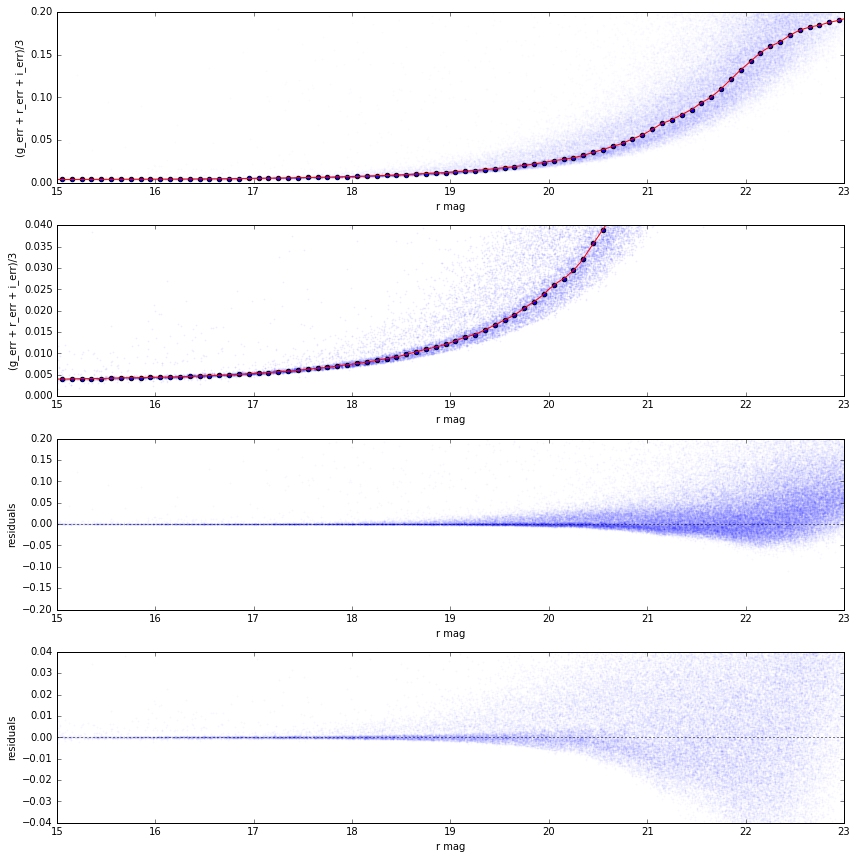

In [258]:
x = cat['r']
y = gri_err


xlims = [15, 23]
ylims = [0, .2]
lims = (xlims[0]<x) & (x<xlims[1]) & (ylims[0]<y) & (y<ylims[1])

binsize = .1
rbins = np.arange(xlims[0], xlims[1]+binsize, binsize)
# first get the values in the bins
binned_errs = [y[(l<x)&(x<u)&(ylims[0]<y)&(y<ylims[1])] for l, u in zip(rbins[:-1], rbins[1:])]
bincens_mag = [(l+u)/2 for l, u in zip(rbins[:-1], rbins[1:])]

#sigma clip and then compute the median of that 
clipped_errs = [sigma_clip(b, sigma=2) for b in binned_errs]
binvalues = [np.median(v[~v.mask])for v in clipped_errs]

mod = lambda x: np.interp(x, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod)
fig.axes[0].scatter(bincens, binvalues)
fig.axes[1].scatter(bincens, binvalues)
plt.tight_layout()

Interesting thing to note: the "double-track" is gone

<Polynomial1D(15, c0=0.005610324489241906, c1=-0.32864884665072697, c2=19.07995914130999, c3=-497.5022892711121, c4=7215.1981343815005, c5=-65022.36494900274, c6=389326.05900405993, c7=-1615140.0449518352, c8=4762867.90245408, c9=-10116350.168626405, c10=15509577.110110871, c11=-16994755.360565256, c12=12970884.72635927, c13=-6546123.411848208, c14=1962525.676999017, c15=-264526.3846137787)>

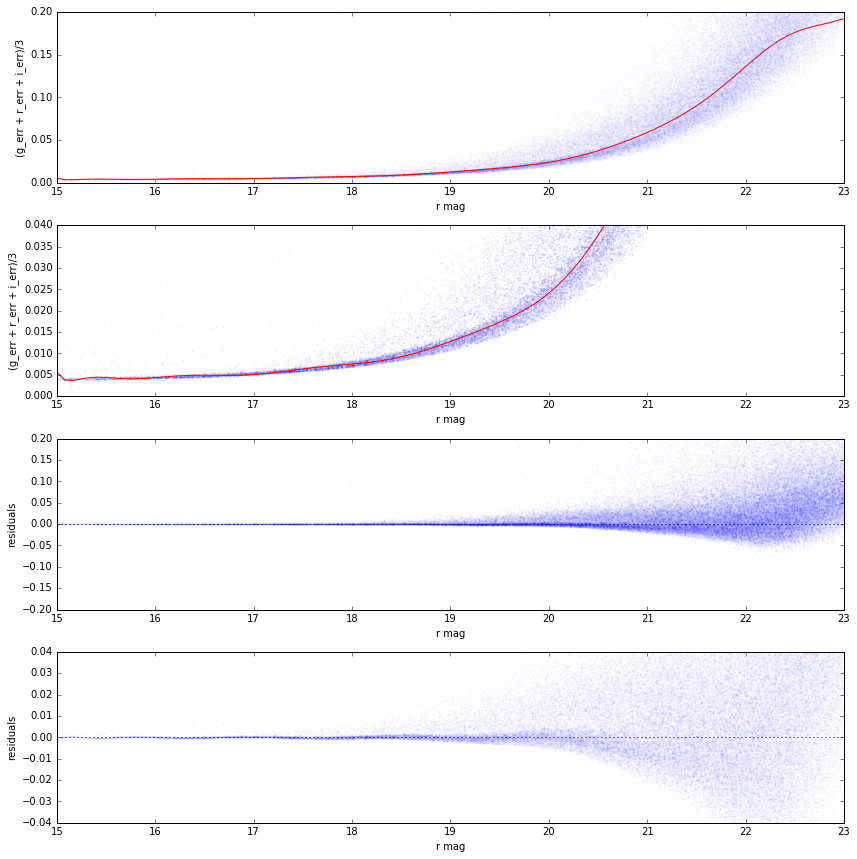

In [259]:
mod0 = modeling.models.Polynomial1D(degree=15, domain=xlims, window=[0, 1])
mod_gilg = modeling.fitting.LinearLSQFitter()(mod0, bincens, binvalues)

fig = plot_data_and_model_residuals(x, y, xlims, ylims, mod_gilg)
plt.tight_layout()
mod_gilg

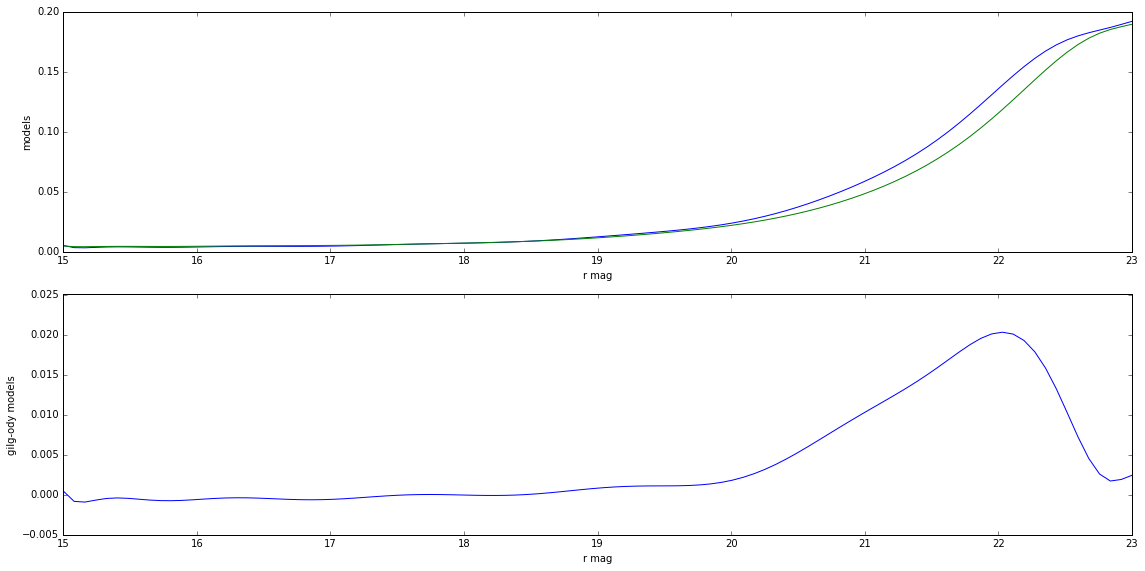

In [260]:
fig, (ax1, ax2) = plt.subplots(2)

x = np.linspace(xlims[0], xlims[1], 100)
ax1.plot(x, mod_gilg(x))
ax1.plot(x, mod_ody(x))

ax2.plot(x, mod_gilg(x)-mod_ody(x))

for ax in (ax1, ax2):
    ax.set_xlabel('r mag')
ax1.set_ylabel('models')
ax2.set_ylabel('gilg-ody models')
plt.tight_layout()

Hmm, looks like it's field-specific...